# Emissions, emissions per capita, and cumulative emissions

In this tutorial I will use openclimate to create a time series emissions and emissions per capita for countries.

In [14]:
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd

In [3]:
from openclimate import Client
client = Client()
client.jupyter

Let's start by getting all the country codes

In [4]:
df_names = client.parts('EARTH')[['actor_id', 'name']]
actor_ids = tuple(client.parts('EARTH')['actor_id'])

## Emissions

Let's use fossil CO2 emissions from the [Global Carbon Budget 2022](https://essd.copernicus.org/articles/14/4811/2022/). 
You can use `client.emissions_datasets()` to list all datasets available.
Be a little patient, this takes about 20 seconds to retrieve the data for 250 countries.

In [6]:
%%time
df_emissions = client.emissions(actor_ids, 'GCB2022:national_fossil_emissions:v1.0')

CPU times: user 4.88 s, sys: 646 ms, total: 5.53 s
Wall time: 15.4 s


This returns a dataframe with `total_emissions` in tonnes of CO2. 

In [7]:
df_emissions.sample(5)

,actor_id,year,total_emissions,datasource_id
133,CA,1899,19170048,GCB2022:national_fossil_emissions:v1.0
121,GE,1919,139804,GCB2022:national_fossil_emissions:v1.0
246,BD,2012,60707807,GCB2022:national_fossil_emissions:v1.0
209,AW,2007,2821280,GCB2022:national_fossil_emissions:v1.0
125,FR,1891,97982688,GCB2022:national_fossil_emissions:v1.0


Lets's first rank the countries by the their emissions in the most recent year and display the top 10 emitters.

In [36]:
year = df_emissions.year.max()
df_recent = (
    df_emissions
    .loc[df_emissions.year == year]
    .assign(rank = lambda x: x['total_emissions'].rank(ascending=False))
    .assign(percent_of_global = lambda x: (x['total_emissions'] / x['total_emissions'].sum()) * 100)
    .sort_values(by='rank')
    .merge(df_names, on='actor_id')
    .loc[:, ['rank', 'name', 'actor_id', 'year', 'total_emissions', 'percent_of_global']]
)
df_recent.head(10)

,rank,name,actor_id,year,total_emissions,percent_of_global
0,1.0,China,CN,2021,11472369170,31.817230
1,2.0,United States of America,US,2021,5007335888,13.887241
2,3.0,India,IN,2021,2709683624,7.514980
3,4.0,Russian Federation,RU,2021,1755547389,4.868799
4,5.0,Japan,JP,2021,1067398435,2.960301
5,6.0,Iran,IR,2021,748878751,2.076925
6,7.0,Germany,DE,2021,674753565,1.871347
7,8.0,Saudi Arabia,SA,2021,672379870,1.864764
8,9.0,Indonesia,ID,2021,619277532,1.717491
9,10.0,"Korea, the Republic of",KR,2021,616074996,1.708610


China was responbible for the lion's share of global CO2 emissions in 2021 at nearly 32%. This is as much as the next 6 countries combined! However, this is just a snapshot in time. Let's plot time series for each of the top 7 emitters.

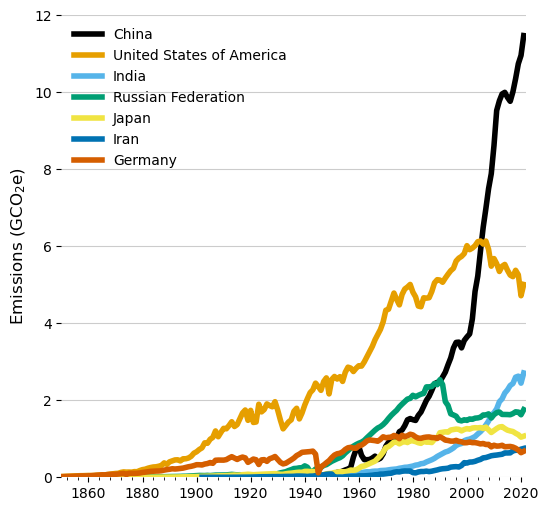

In [15]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# top 7 emitters
top_emitters = list(df_recent.head(7).actor_id)

# wong color palette (https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40)
colors = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
    
for actor_id, color in zip(top_emitters, cycle(colors)):
    
    actor_name = df_names.loc[df_names['actor_id'] == actor_id, 'name'].values[0]
    filt = df_emissions['actor_id'] == actor_id
    df_tmp = df_emissions.loc[filt]
    
    ax.plot(df_tmp['year'], df_tmp['total_emissions']/10**9,
            linewidth=4,
            label = actor_name,
            color=color)

    ylim = [0, 12]
    ax.set_ylim(ylim)
    ax.set_xlim([1850, 2022])

    # Turn off the display of all ticks.
    ax.tick_params(which='both',     # Options for both major and minor ticks
                   top='off',        # turn off top ticks
                   left='off',       # turn off left ticks
                   right='off',      # turn off right ticks
                   bottom='off')     # turn off bottom ticks

    # Remove x tick marks
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # major/minor tick lines
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(axis='y',
            which='major',
            color=[0.8, 0.8, 0.8], linestyle='-')

    ax.set_ylabel("Emissions (GCO$_2$e)", fontsize=12)
    ax.legend(loc='upper left', frameon=False)

This tells a richer story. Now we see the US was the main annual contributor up until about the year 2000. After which, Chinese emissions sky rocketed while US emissions started declining.

An interesting feature in this graph is the dramatic drop in Russian emissions. This corresponds to the fall of the Soviet Union, which led to a huge drop in emissions. Key drivers of the emissions reductions were the decreasing beef consumption in the 1990s and carbon sequestration in soils on abandoned cropland [Schierhorn et al., (2019)](https://iopscience.iop.org/article/10.1088/1748-9326/ab1cf1/meta).

## Emissions per capita

now let's retrieve population data and calulate emissions per capita

In [23]:
df_pop = client.population(tuple(df_recent.head(7)['actor_id']))
df_percap = pd.merge(df_emissions, df_pop, on=['actor_id', 'year'])[['actor_id', 'year', 'total_emissions', 'population']]
df_percap = df_percap.assign(total_emissions_per_capita = lambda x: x['total_emissions'] / (x['population']))

In [24]:
year = df_percap.year.max()
df_recent_percap = (
    df_percap
    .loc[df_percap.year == year]
    .assign(rank = lambda x: x['total_emissions_per_capita'].rank(ascending=False))
    .assign(percent_of_global = lambda x: (x['total_emissions'] / x['total_emissions'].sum()) * 100)
    .sort_values(by='rank')
    .merge(df_names, on='actor_id')
    .loc[:, ['rank', 'name', 'actor_id', 'year', 'total_emissions', 'percent_of_global']]
)

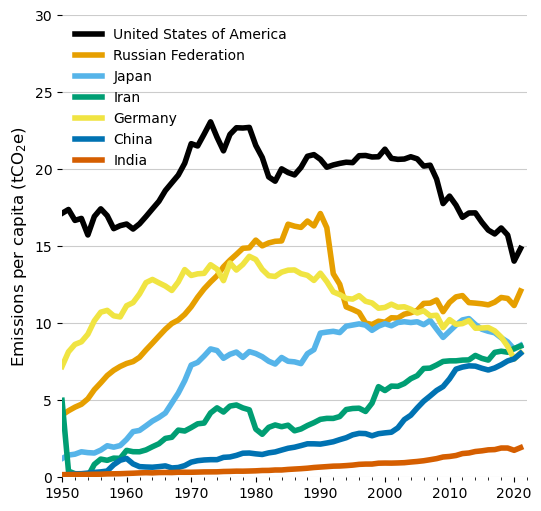

In [25]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# top 7 emitters
top_emitters = list(df_recent_percap.head(7).actor_id)

# wong color palette (https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40)
colors = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
    
for actor_id, color in zip(top_emitters, cycle(colors)):
    
    actor_name = df_names.loc[df_names['actor_id'] == actor_id, 'name'].values[0]
    filt = df_percap['actor_id'] == actor_id
    df_tmp = df_percap.loc[filt]

    ax.plot(df_tmp['year'], df_tmp['total_emissions_per_capita'],
            linewidth=4,
            label = actor_name,
            color=color)

    ylim = [0, 30]
    ax.set_ylim(ylim)
    ax.set_xlim([1950, 2022])

    # Turn off the display of all ticks.
    ax.tick_params(which='both',     # Options for both major and minor ticks
                   top='off',        # turn off top ticks
                   left='off',       # turn off left ticks
                   right='off',      # turn off right ticks
                   bottom='off')     # turn off bottom ticks

    # Remove x tick marks
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # major/minor tick lines
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(axis='y',
            which='major',
            color=[0.8, 0.8, 0.8], linestyle='-')

    ax.set_ylabel("Emissions per capita (tCO$_2$e)", fontsize=12)
    ax.legend(loc='upper left', frameon=False)

Looking at emissions per capita, we see that US has consistently had the largest emissions intensity over this period.  

## Cumulative emissions
Finally, let's calculate cumulative emissions, which tells us how much CO2 each actor has emitted in total since a specified start date. Here the start date is 1850, which is a pre-industrial period before large influences from human activity. 

In [31]:
df_emissions = df_emissions.assign(cumulative_emissions = df_emissions.groupby('actor_id')['total_emissions'].cumsum())

In [ ]:
year = df_emissions.year.max()
df_recent_emissions = (
    df_emissions
    .loc[df_emissions.year == year]
    .assign(rank = lambda x: x['cumulative_emissions'].rank(ascending=False))
    .sort_values(by='rank')
    .merge(df_names, on='actor_id')
    .loc[:, ['rank', 'name', 'actor_id', 'year', 'total_emissions']]
)

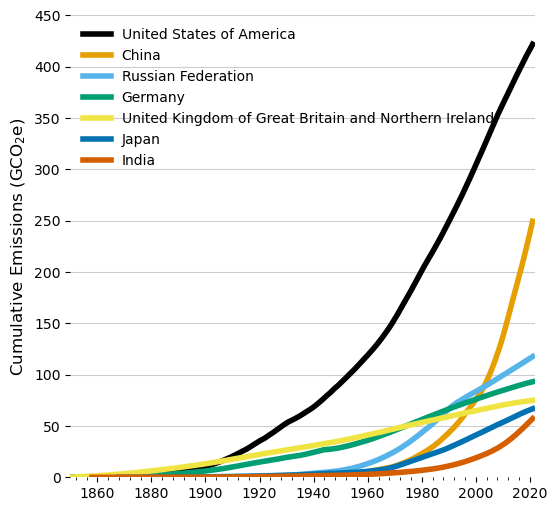

In [41]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# top 8 emitters
top_emitters = list(df_recent_emissions.head(7).actor_id)

# wong color palette (https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40)
colors = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
    
for actor_id, color in zip(top_emitters, cycle(colors)):
    
    actor_name = df_names.loc[df_names['actor_id'] == actor_id, 'name'].values[0]
    filt = df_emissions['actor_id'] == actor_id
    df_tmp = df_emissions.loc[filt]
    
    ax.plot(df_tmp['year'], df_tmp['cumulative_emissions']/10**9,
            linewidth=4,
            label = actor_name,
            color=color)

    ylim = [0, 450]
    ax.set_ylim(ylim)
    ax.set_xlim([1850, 2022])

    # Turn off the display of all ticks.
    ax.tick_params(which='both',     # Options for both major and minor ticks
                   top='off',        # turn off top ticks
                   left='off',       # turn off left ticks
                   right='off',      # turn off right ticks
                   bottom='off')     # turn off bottom ticks

    # Remove x tick marks
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # major/minor tick lines
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(axis='y',
            which='major',
            color=[0.8, 0.8, 0.8], linestyle='-')

    ax.set_ylabel("Cumulative Emissions (GCO$_2$e)", fontsize=12)
    ax.legend(loc='upper left', frameon=False)
    
    # linear line
    #ax.plot([1880, 2020],[0, 75],'--', color=[0.5,0.5,0.5])

Now we see the UK show up, which didn't appear as a top annual emitter or per-capita. In general, the reason has to do with the rate of increase. UK has an almost linear rate of incrase in cumulative emissions while most of the other countries have an increasing rate. 